# Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

<img src="../images/galaxy_vs_quasar_1.png" alt="Description" width="1000" />

<img src="../images/galaxy_vs_quasar_2.png" alt="Description" width="1000" />

SDSS observed in four bands:

<img src="../images/galaxy_vs_quasar_3.png" alt="Description" width="600" />

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [86]:
import numpy as np
import pylab as plt
import warnings
warnings.filterwarnings("ignore")


data=np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
#data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [64]:
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [65]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [66]:
d = dict(zip(names, data.T))
d

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

In [67]:
lab=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
lab

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [68]:
set(lab)

{'GALAXY', 'QSO'}

In [69]:
# Build colors

for diff in ['ug', 'gr', 'ri', 'iz']:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

In [70]:
d.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'lab'])

# Quick exploration

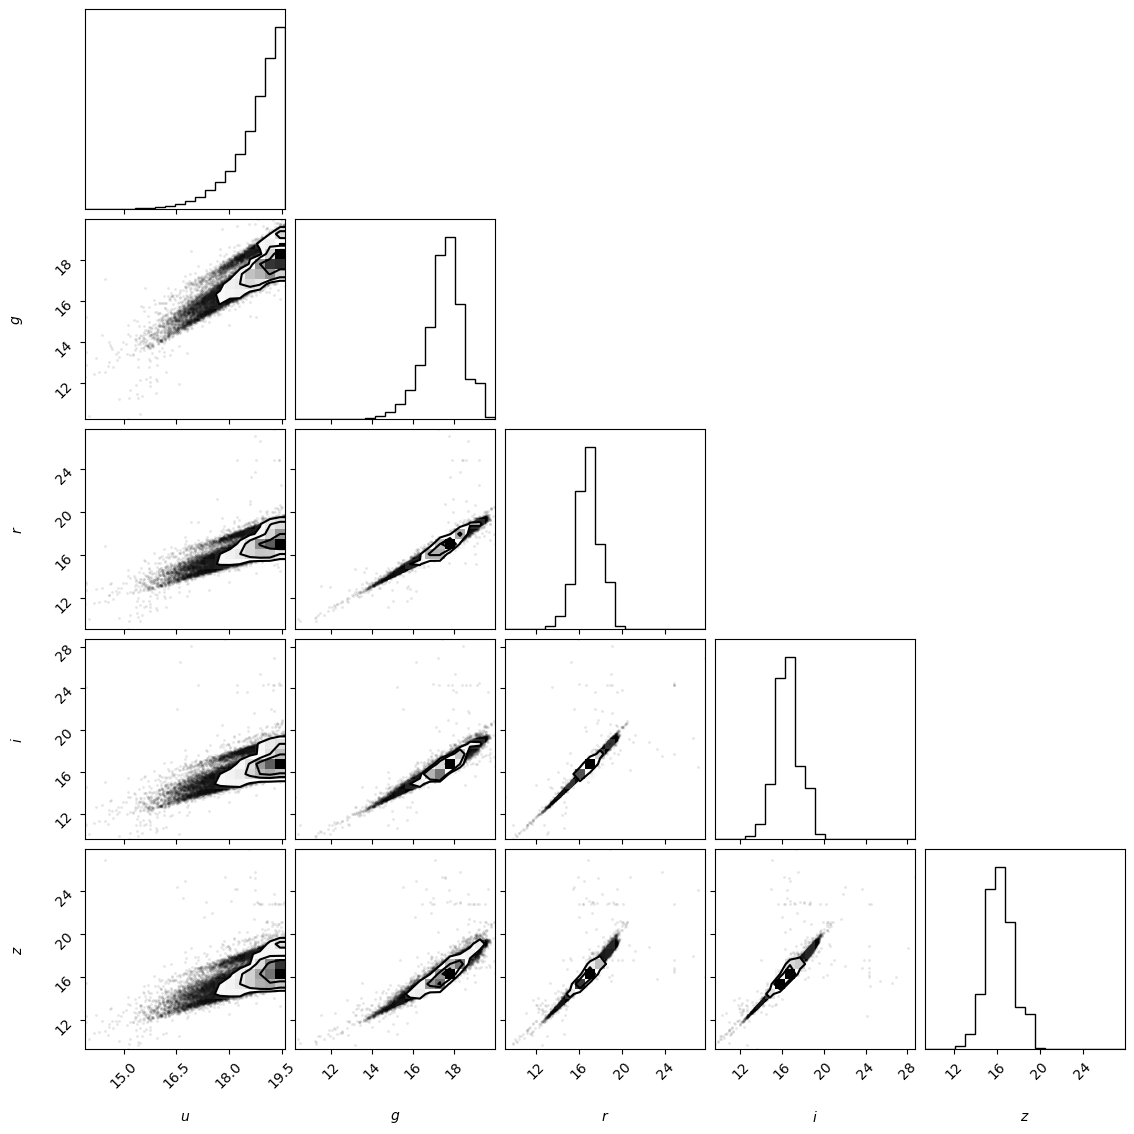

In [90]:
import corner
corner.corner(np.array([d['u'],d['g'],d['r'],d['i'],d['z']]).T, labels=['$u$', '$g$', '$r$', '$i$', '$z$']);

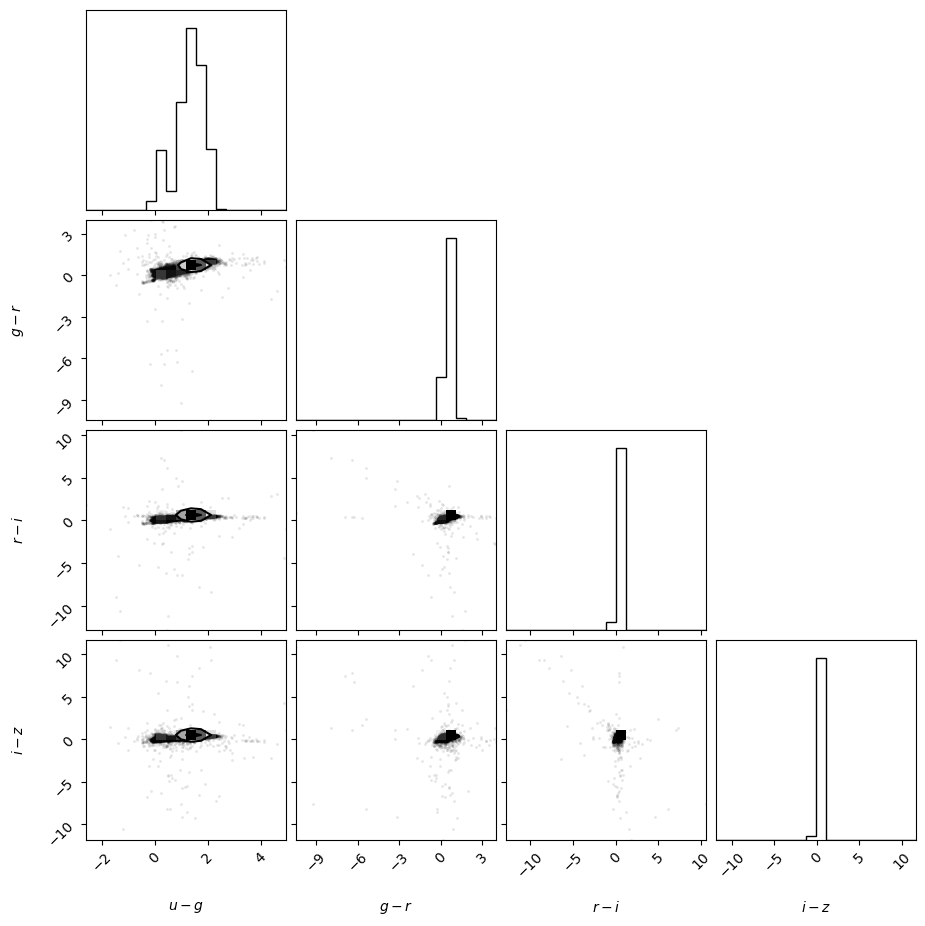

In [73]:
corner.corner(np.array([d['ug'],d['gr'],d['ri'],d['iz']]).T, labels=['$u-g$', '$g-r$', '$r-i$', '$i-z$']);

### We see a bimodality in the u - g color

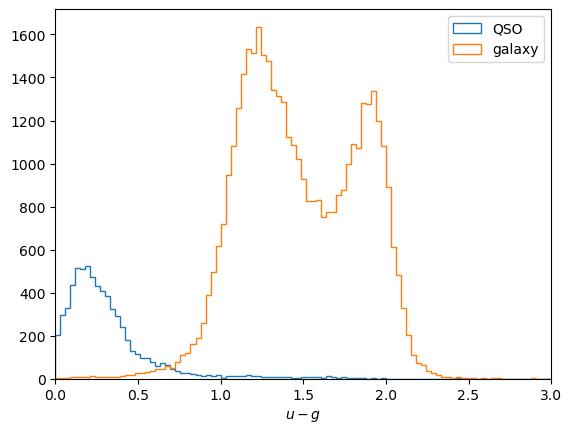

In [75]:
plt.hist(d['ug'][lab=='QSO'],histtype='step',bins=np.linspace(0,3,100),label='QSO')
plt.hist(d['ug'][lab=='GALAXY'],histtype='step',bins=np.linspace(0,3,100),label='galaxy')
plt.xlim(0,3)

plt.legend()
plt.xlabel('$u-g$')
plt.show()

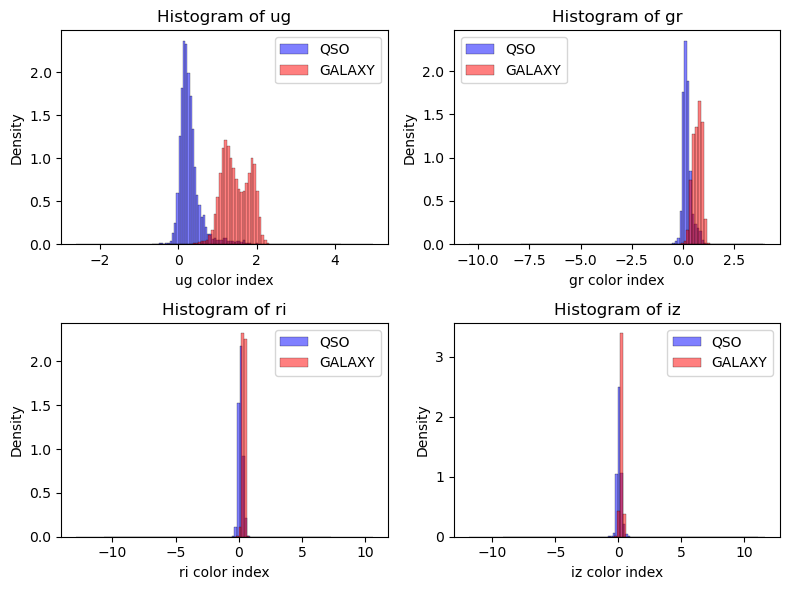

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for ax, color in zip(axs.flatten(), ['ug', 'gr', 'ri', 'iz']):
    # Plot for QSO
    sns.histplot(d[color][lab == 'QSO'],bins=100,color='blue',alpha=0.5,label='QSO',stat='density',ax=ax)
    
    # Plot for GALAXY
    sns.histplot(d[color][lab == 'GALAXY'],bins=100,color='red',alpha=0.5,label='GALAXY',stat='density',ax=ax)
    
    ax.set_title(f'Histogram of {color}')
    ax.set_xlabel(f'{color} color index')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


## Machine learning

In [315]:
X=np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = np.array(lab=='QSO',dtype=int)

In [316]:
import sklearn.model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

In [317]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=67)

In [318]:
X_train.shape

(33500, 4)

### Gaussian naive bayes 

***Training Phase***

Given a labeled dataset with continuous features and classes:
$$
\{(X^{(1)}, C^{(1)}), (X^{(2)}, C^{(2)}), \ldots, (X^{(N)}, C^{(N)})\}
$$

where $X^{(j)} = (x^{(j)}_1, x^{(j)}_2, \ldots, x^{(j)}_n)$ is the feature vector and $C^{(j)}$ is the class label.

For each class $C_k$:
- **Estimate the prior probability**:
  $$
  P(C_k) = \frac{\text{Number of samples in } C_k}{\text{Total number of samples}}
  $$
- **Estimate the mean and variance of each feature**:
  $$
  \mu_{k,i} = \frac{1}{N_k} \sum_{j \in C_k} x^{(j)}_i
  $$
  $$
  \sigma^2_{k,i} = \frac{1}{N_k} \sum_{j \in C_k} \left(x^{(j)}_i - \mu_{k,i}\right)^2
  $$

where $N_k$ is the number of samples in class $C_k$.

---

***Prediction Phase***

Given a new, unlabeled example $X = (x_1, x_2, \ldots, x_n)$:
- For each class $C_k$:
  - Calculate the **likelihood** of $X$ given $C_k$ using the Gaussian formula:
    $$
    P(X \mid C_k) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma_{k,i}^2}} \exp \left( -\frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2} \right)
    $$
  - Multiply by the **prior**:
    $$
    P(C_k) \cdot P(X \mid C_k)
    $$

- Select the class with the highest posterior probability:
  $$
  \hat{C} = \arg\max_{C_k} \left[ P(C_k) \cdot P(X \mid C_k) \right]
  $$

In [319]:
print(X_train[y_train==0].shape)
print(X_train[y_train==1].shape)

(28687, 4)
(4813, 4)


In [320]:
print(X_train[y_train==0,0])

[1.50452 1.2846  1.11076 ... 1.25841 1.36609 0.4885 ]


In [321]:
def log_likelihood(X, k, mean, std):
    """
    Compute the log-likelihood(s) for input(s) X given class k.

    Parameters:
    - X: numpy array, shape (n_samples, n_features) 
    - k: class index
    - mean: numpy array, shape (n_classes, n_features)
    - std: numpy array, shape (n_classes, n_features)

    Returns:
    - log_prob: numpy array of shape (n_samples,) or a scalar
    """
    n_features = X.shape[1]
    
    constant = -0.5 * np.sum(np.log(2 * np.pi * (std[k] ** 2)))
    
    quadratic = -0.5 * np.sum(((X - mean[k]) ** 2) / (std[k] ** 2), axis=1)
    
    log_prob = constant + quadratic

    return log_prob

In [322]:
mean = [[] for _ in np.unique(y)]
std = [[] for _ in np.unique(y)]

# loop on the classes
for k in np.unique(y):

    # loop on number of features
    for i in range(X_train.shape[1]):

        mean[k].append(np.mean(X_train[y_train==k,i]))
        std[k].append(np.std(X_train[y_train==k,i]))

mean = np.array(mean)
std = np.array(std)

print(mean)
print(std)

[[1.47832387 0.70324899 0.37678248 0.25682265]
 [0.2991899  0.19563024 0.14107093 0.07649158]]
(2, 4)
[[0.36403824 0.24889606 0.17094623 0.26800591]
 [0.32163589 0.23937753 0.20184805 0.18799656]]


In [332]:
# select number of features
n_feat = 2

In [331]:
mean_ = mean[:,0:n_feat]
std_ = std[:,0:n_feat]
print(mean_)

[[1.47832387 0.70324899 0.37678248]
 [0.2991899  0.19563024 0.14107093]]


In [337]:
ug = np.linspace(-2, 4, 100)
gr = np.linspace(-2, 4, 100)
ri = np.linspace(-2, 4, 100)
iz = np.linspace(-2, 4, 100)

xx, yy = np.meshgrid(ug, gr)

In [ ]:
# To be finished!!!

In [338]:
print(xx.shape)

(100, 100)


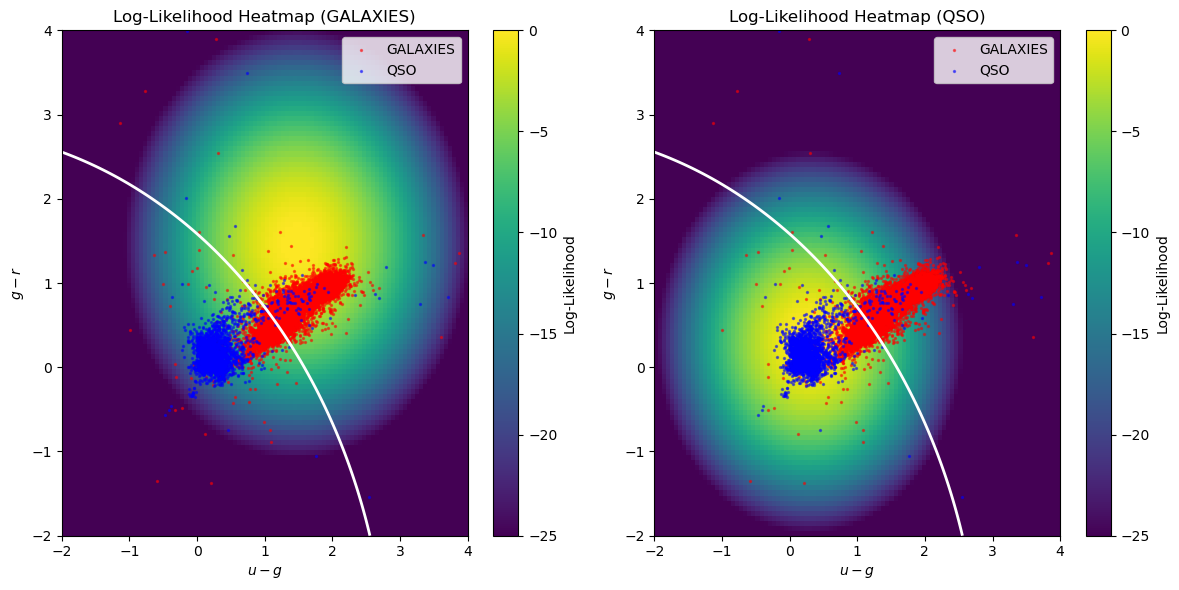

In [303]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Precompute log-probabilities for both classes
log_prob_0 = np.zeros_like(xx)
log_prob_1 = np.zeros_like(xx)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point = np.array([[xx[i, j], yy[i, j]]])
        log_prob_0[i, j] = log_likelihood(point, 0, mean, std)
        log_prob_1[i, j] = log_likelihood(point, 1, mean, std)

# Difference of log-probabilities (class 1 minus class 0)
delta_log_prob = log_prob_1 - log_prob_0

# Plot each class heatmap
for k in [0, 1]:
    im = ax[k].imshow([log_prob_0, log_prob_1][k],extent=[-2, 4, -2, 4],origin='lower',cmap='viridis',aspect='auto',vmax=0,vmin=-25)
    plt.colorbar(ax=ax[k], mappable=im, label='Log-Likelihood')
    ax[k].set_xlabel('$u-g$')
    ax[k].set_ylabel('$g-r$')
    label = 'GALAXIES' if k == 0 else 'QSO' 
    ax[k].set_title(f'Log-Likelihood Heatmap ({label})')

    # Scatter plot
    ax[k].scatter(X_test[y_test==0,0][::1], X_test[y_test==0,1][::1], c='r', s=2, alpha=0.5, label='GALAXIES')
    ax[k].scatter(X_test[y_test==1,0][::1], X_test[y_test==1,1][::1], c='b', s=2, alpha=0.5, label='QSO')
    ax[k].set_xlim(-2,4)
    ax[k].set_ylim(-2,4)

    # Add decision boundary (where delta_log_prob == 0)
    cs = ax[k].contour(
        xx, yy, delta_log_prob,
        levels=[0],
        colors='white',
        linewidths=2
    )
    #ax[k].clabel(cs, fmt='Decision Boundary', colors='white')

    ax[k].legend()

plt.tight_layout()
plt.show()

In [ ]:
for i in range(4):

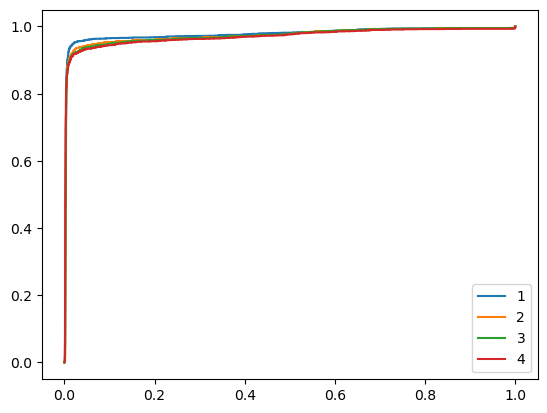

In [290]:
# With sklearn

clf = GaussianNB()

for i in range(4):

    clf.fit(X_train[:,0:i+1] ,y_train )

    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
plt.legend()